# Laboratory work  2

**Фильтрация изображений**

Completed: гр.№ 6131-010402D, Griaznov Ilia

In [26]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2 as cv
import random
import copy
import json
from itertools import repeat
import cv2

In [27]:
RANK = 1
kernel = np.array([[2, 1, 2],
                   [1, 1, 1],
                   [2, 1, 2]], dtype='uint8')

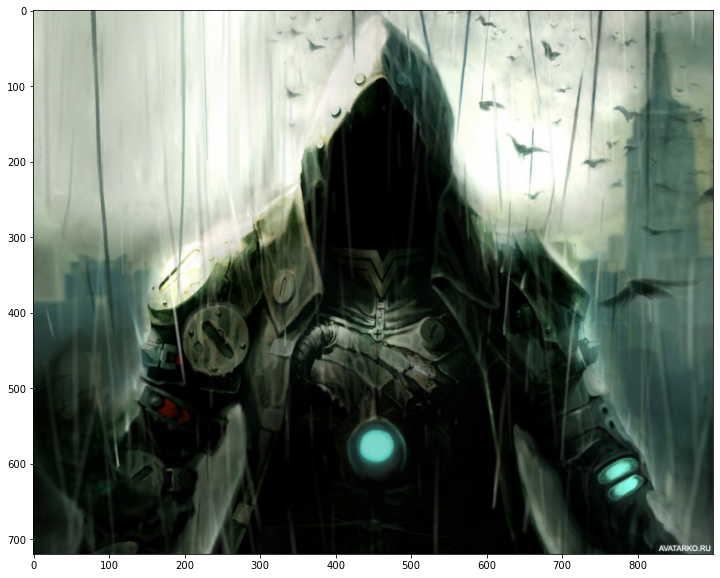

In [28]:
image = plt.imread('Assassins_Creed.jpg')
fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(image)

In [29]:
image.shape

(720, 900, 3)

Функция добавления шума

In [30]:
def sp_noise(image,prob): #Зашумить изображение аддитивным шумом с вероятностью p (по вариантам).
  '''
  Add salt and pepper noise to image
  prob: Probability of the noise
  '''
  output = np.zeros(image.shape,np.uint8)
  thres = 1 - prob 
  for i in range(image.shape[0]):
      for j in range(image.shape[1]):
          rdn = random.random()
          if rdn < prob:
              output[i][j] = 0
          elif rdn > thres:
              output[i][j] = 255
          else:
              output[i][j] = image[i][j]
  return output

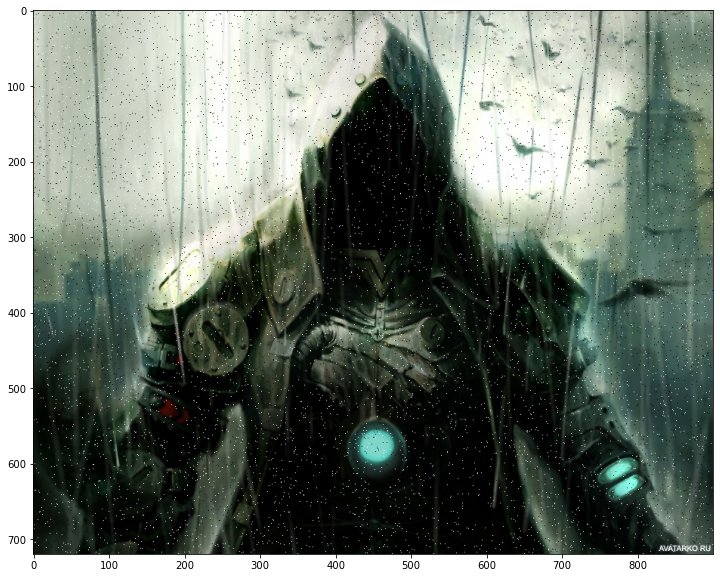

In [31]:
noise_img = sp_noise(image,0.01)
fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(noise_img)

In [32]:
def median_filter(image, kernel):
  output_img = np.copy(image)
  M,N = kernel.shape[0], kernel.shape[1]
  kernel = kernel.flatten()
  for i in range(image.shape[0]-M+1):
    for j in range(image.shape[1]-N+1):
      temp_rgb = image[i:i+M,j:j+N,:]
      for k in range(image.shape[2]):
        list = []
        tmp = temp_rgb[:,:,k].flatten()
        for t in range(len(tmp)):
          list.extend(repeat(tmp[t], kernel[t]))
        output_img[i,j,k] = np.sort(list, axis=None)[len(list)//2]
  return output_img

In [33]:
def median_filter_rang(image, kernel, rang):
  output_img = np.copy(image)
  M,N = kernel.shape[0], kernel.shape[1]
  kernel = kernel.flatten()
  for i in range(image.shape[0]-M+1):
    for j in range(image.shape[1]-N+1):
      temp_rgb = image[i:i+M,j:j+N,:]
      for k in range(image.shape[2]):
        list = []
        tmp = temp_rgb[:,:,k].flatten()
        for t in range(len(tmp)):
          list.extend(repeat(tmp[t], kernel[t]))
        output_img[i,j,k] = np.sort(list, axis=None)[rang]
  return output_img

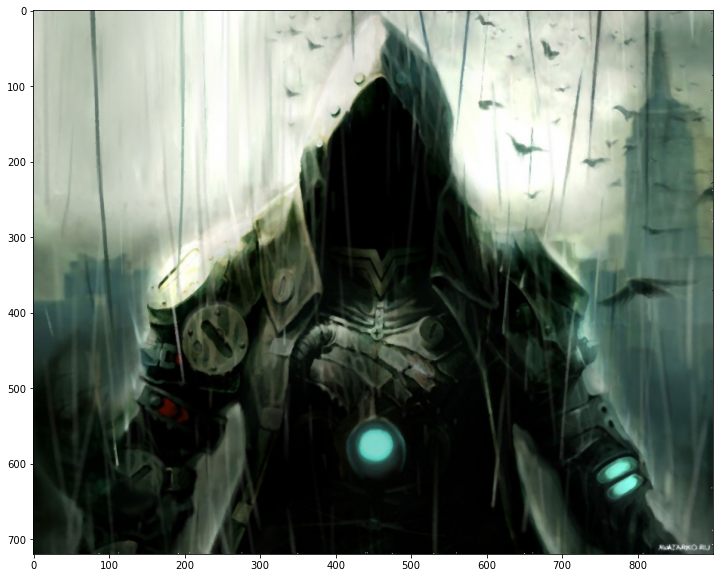

In [34]:
filter = median_filter(noise_img, kernel)
fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(filter)

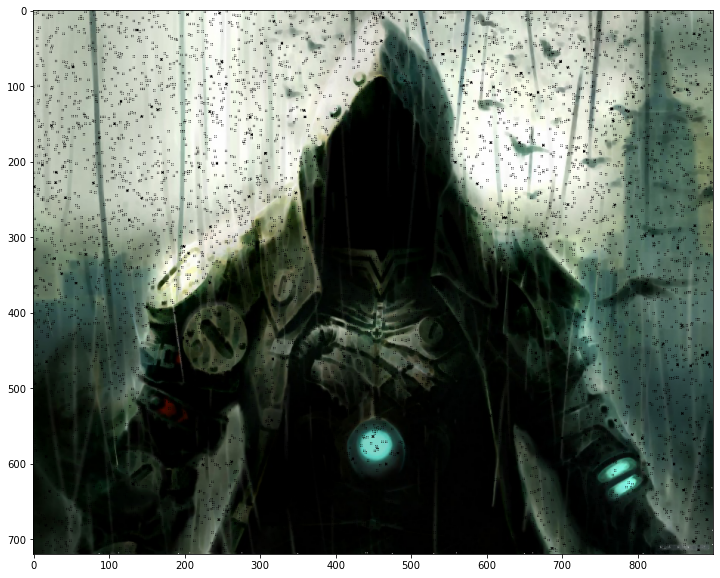

In [35]:
rang = median_filter_rang(noise_img, kernel, 1)
fig, ax = plt.subplots(figsize=(15,10))
ax.imshow(rang)

In [36]:
def rmse(orig, mod):
    return np.sqrt(np.mean((orig - mod) ** 2))

In [37]:
rang_list = [0,1,2,3,4,5,6]
channel = [0, 1, 2]
for i in rang_list:
  rang_image = median_filter_rang(image, kernel, i)
  mse = 0
  for j in channel:
    mse += np.mean((image[:,:,j] - rang_image[:,:,j])**2)
  print("RMSE: ", mse/3, ", rang: ", i)

RMSE:  28.181700102880658 , rang:  0
RMSE:  27.279366769547323 , rang:  1
RMSE:  23.78130864197531 , rang:  2
RMSE:  21.092953703703703 , rang:  3
RMSE:  19.852968621399175 , rang:  4
RMSE:  19.562416666666667 , rang:  5
RMSE:  19.40111111111111 , rang:  6


In [38]:
# вариант
p = 0.1
window = np.array([[2, 1, 2], [1, 1, 1], [2, 1, 2]]) * 1 / 13

In [39]:
def add_noise(pixels, threshold):
    index = np.random.rand(pixels.shape[0], pixels.shape[1])
    result = np.copy(pixels)
    result[index < threshold] = 255
    return result

In [40]:
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image_noise = add_noise(image_gray, p)

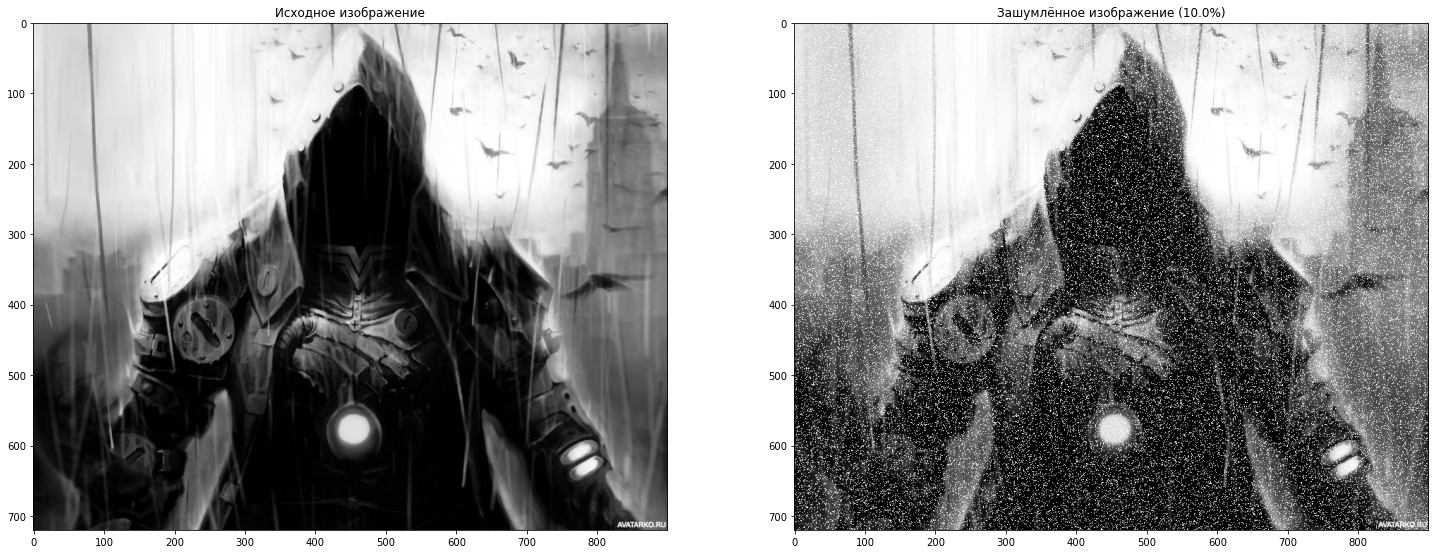

In [41]:
fig, ax = plt.subplots(1, 2, figsize=(25, 10))

ax[0].imshow(image_gray, vmin=0, vmax=255,  cmap='Greys_r')
ax[0].set(title='Исходное изображение')
ax[1].imshow(image_noise, vmin=0, vmax=255,  cmap='Greys_r')
ax[1].set(title='Зашумлённое изображение ({}%)'.format(p * 100))

plt.show()

### КИХ-фильтр
 - КИХ = finite impulse response (FIR) filter

In [42]:
def fir_filter_image(image, weighted_window):
  return cv2.merge(list(map(lambda channel: fir_filter(channel, weighted_window), cv2.split(image))))

def fir_filter(image, weighted_window):
  h, w = image.shape
  window_h, window_w = weighted_window.shape
  new_image = np.zeros((h, w), np.uint8)
  # ddepth = -1, выходное изображение имеет ту же глубину, что и исходное
  new_image = cv2.filter2D(image, -1, weighted_window)
  return new_image

In [43]:
def get_error(img1, img2):
    img1 = img1 / 255
    img2 = img2 / 255
    h, w = img1.shape[0], img1.shape[1]
    return (np.sum((np.array(img1.flatten()) - np.array(img2.flatten())) ** 2) / (h * w * 3)) ** 0.5

Error: 0.0593484888654276


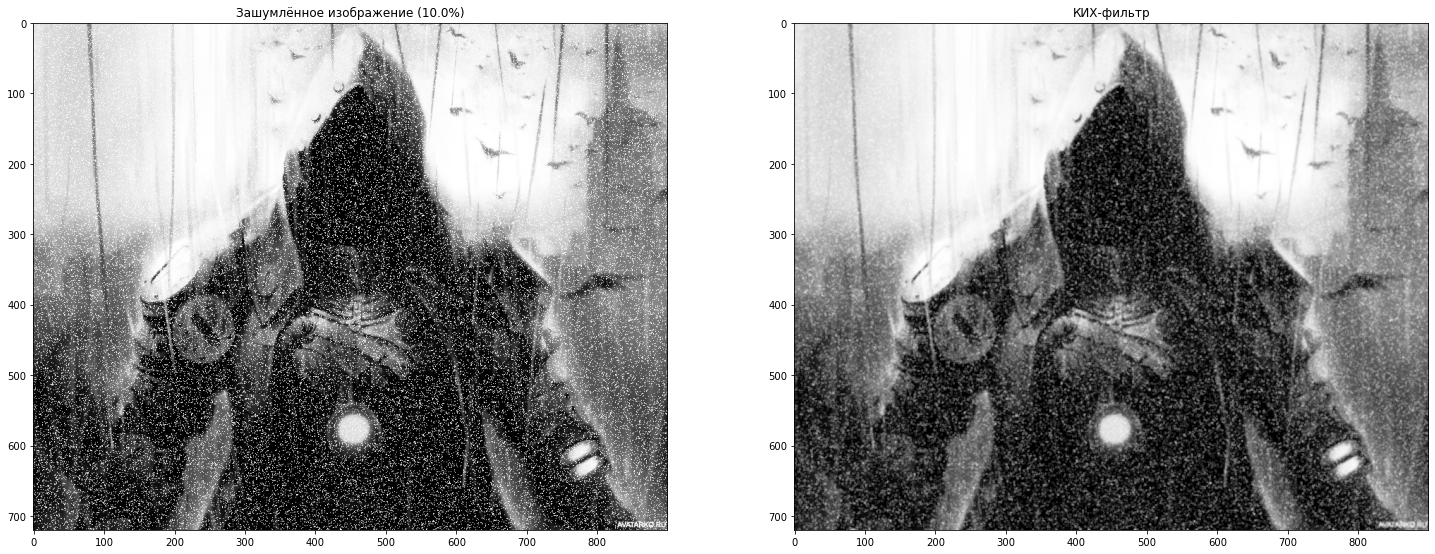

In [44]:
fig, ax = plt.subplots(1, 2, figsize=(25, 10))

image_fir = fir_filter_image(image_noise, window)
print("Error:", get_error(image_gray, image_fir))
ax[0].imshow(image_noise, vmin=0, vmax=255, cmap='Greys_r')
ax[0].set(title='Зашумлённое изображение ({}%)'.format(p * 100))
ax[1].imshow(image_fir, vmin=0, vmax=255,  cmap='Greys_r')
ax[1].set(title='КИХ-фильтр')
plt.show()

## Спектры

In [45]:
tuple([slice(0, int(sz)) for sz in np.array(image_gray.shape)])

(slice(0, 720, None), slice(0, 900, None))

In [46]:
2 ** np.ceil(np.log2(np.array(image_gray.shape))).astype(int)

array([1024, 1024], dtype=int32)

In [47]:
def filtering_fft(image, kernel):
  
  s1 = np.array(image.shape)

  fsize = 2 ** np.ceil(np.log2(s1)).astype(int)
  fslice = tuple([slice(0, int(sz)) for sz in s1])

  image_fft = np.fft.fft2(image , fsize)

  kernel_fft = np.fft.fft2(kernel , fsize)
  result = np.fft.ifft2(image_fft * kernel_fft)[fslice].copy()

  return np.array(result.real , np.int32)

Error: 0.06216928539161808


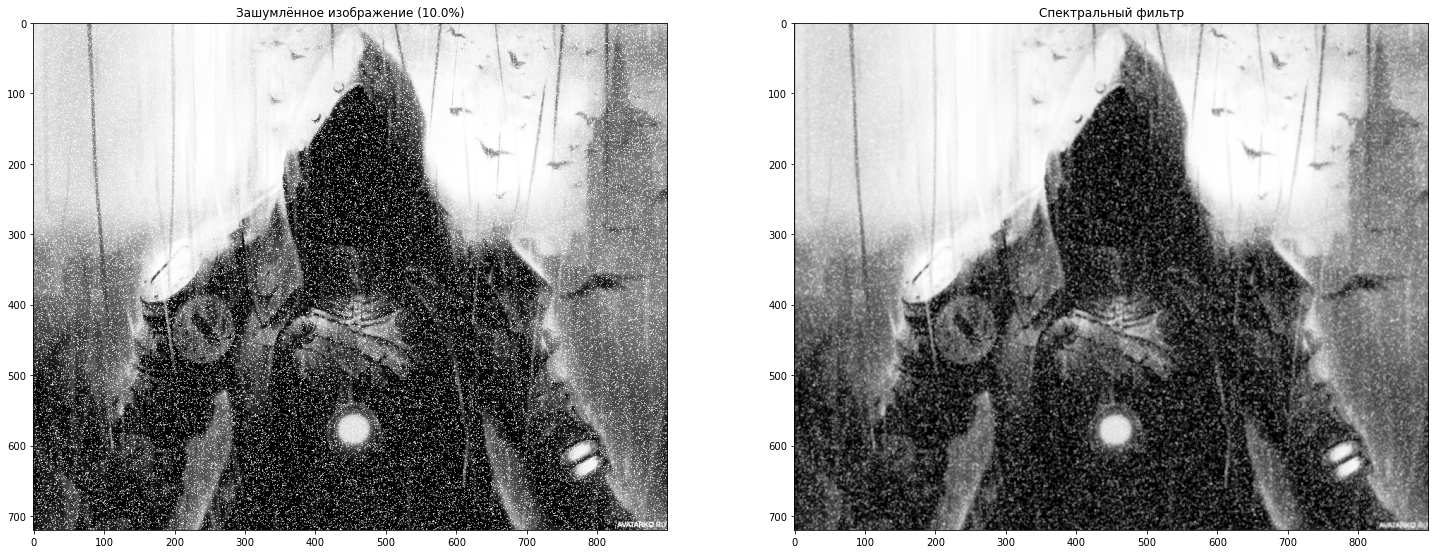

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(25, 10))

image_spectral =  filtering_fft(image_noise, window)
print("Error:", get_error(image_gray, image_spectral))
ax[0].imshow(image_noise, vmin=0, vmax=255, cmap='Greys_r')
ax[0].set(title='Зашумлённое изображение ({}%)'.format(p * 100))
ax[1].imshow(image_spectral, vmin=0, vmax=255, cmap='Greys_r')
ax[1].set(title='Спектральный фильтр')
plt.show()

In [49]:
image_spectral.shape

(720, 900)

In [50]:
image_noise.shape

(720, 900)